In [3]:
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.coords import BoundingBox
from shapely.geometry import box, mapping
from rasterio.merge import merge
from rasterio.plot import show
from affine import Affine
from rasterio.enums import Resampling
from pyproj import Transformer
from shapely.ops import transform
import rasterio.features
import rasterio.windows

In [4]:
solar_points = gpd.read_file("271110_query_points.gpkg")

In [5]:
solar_points.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
display(solar_points)

,id,osm_id,geometry
0,p_1,271110,POINT (4.72567 52.32108)
1,p_2,271110,POINT (4.72599 52.32916)
2,p_3,271110,POINT (4.7263 52.33725)
3,p_4,271110,POINT (4.72662 52.34534)
4,p_5,271110,POINT (4.72693 52.35343)
...,...,...,...
429,p_430,271110,POINT (5.02106 52.29335)
430,p_431,271110,POINT (5.02142 52.30143)
431,p_432,271110,POINT (5.02179 52.30952)
432,p_433,271110,POINT (5.02216 52.31761)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1992, 'height': 2003, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32631"]]'), 'transform': Affine(0.5, 0.0, 627916.5,
       0.0, -0.5, 5804953.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
EPSG:32631


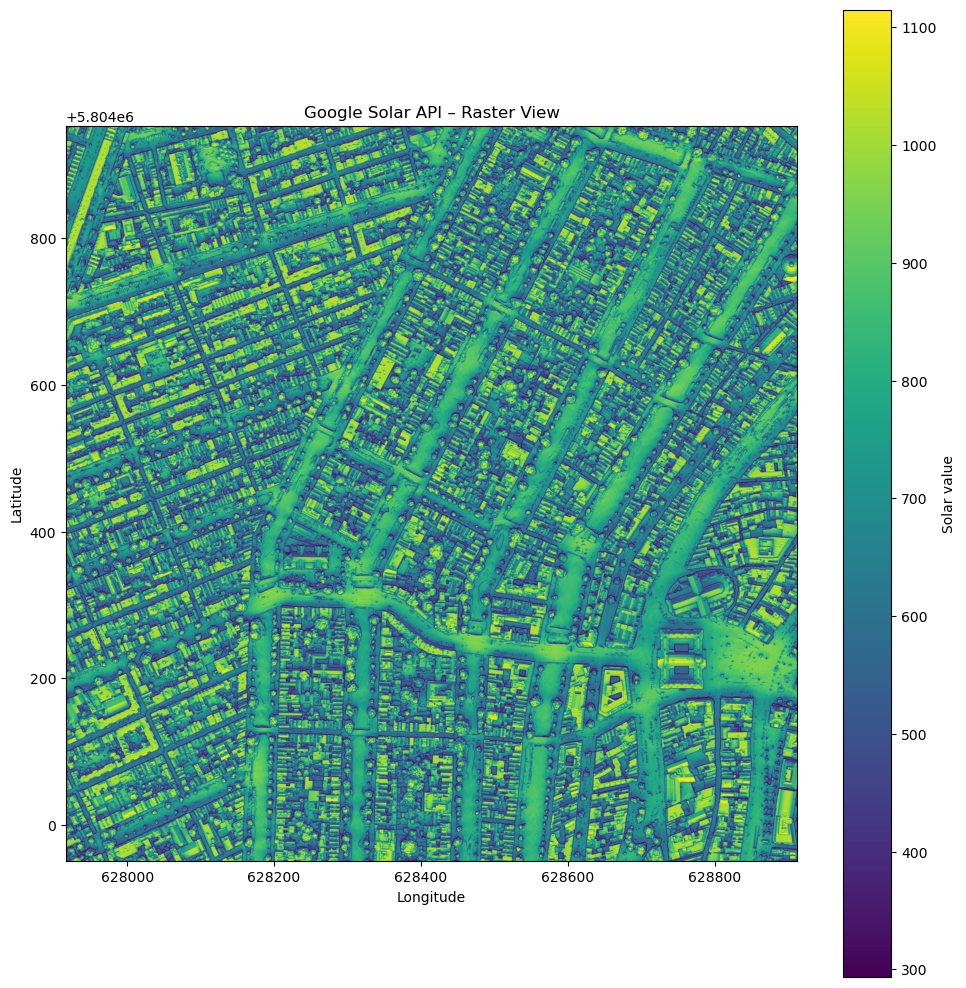

In [7]:
tif_path = 'annual_flux_files/271110_p_176_2022_06_02_annualFlux.tif'
with rasterio.open(tif_path) as src:
    data = src.read(1)  # Read the first band
    profile = src.profile
    print(profile)
    print(src.crs)
    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]

# Plot using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='viridis', extent=extent)
plt.colorbar(label='Solar value')  # You can update this label based on what the raster represents
plt.title("Google Solar API – Raster View")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [8]:
flux_folder = Path("annual_flux_files")

# Get all .tif files with "2022" in the name
tif_files_2022 = sorted(flux_folder.glob("*2022*.tif"))

# Preview
print(f"Found {len(tif_files_2022)} files")

Found 140 files


In [9]:
total_bounds = None

# Loop through each raster to expand the bounds
for tif_path in tif_files_2022:
    with rasterio.open(tif_path) as src:
        bounds = src.bounds  # returns BoundingBox(minx, miny, maxx, maxy)
        if total_bounds is None:
            total_bounds = bounds
        else:
            total_bounds = BoundingBox(
                left=min(total_bounds.left, bounds.left),
                bottom=min(total_bounds.bottom, bounds.bottom),
                right=max(total_bounds.right, bounds.right),
                top=max(total_bounds.top, bounds.top)
            )

# Result: total_bounds contains the full spatial extent
print("Total extent of 2022 solar flux rasters:")
print(f"Left  : {total_bounds.left}")
print(f"Right : {total_bounds.right}")
print(f"Bottom: {total_bounds.bottom}")
print(f"Top   : {total_bounds.top}")

Total extent of 2022 solar flux rasters:
Left  : 626116.5
Right : 639712.5
Bottom: 5793288.5
Top   : 5810353.0


/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/rasterio/merge.py:217: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


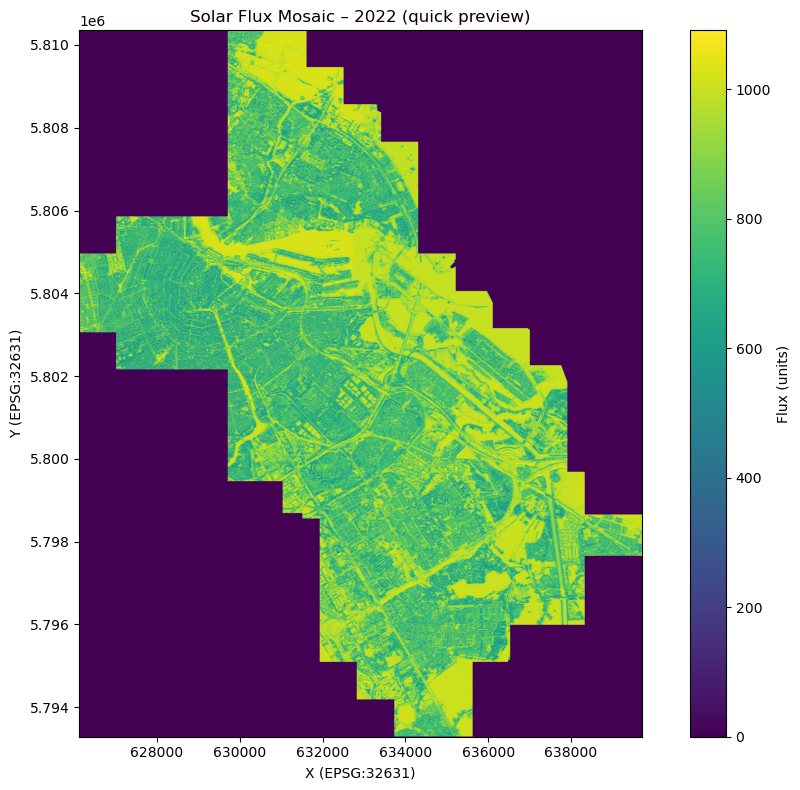

In [10]:
flux_folder = Path("annual_flux_files")
tif_files_2022 = sorted(flux_folder.glob("*2022*.tif"))
srcs = [rasterio.open(p) for p in tif_files_2022]

# Compute overall bounds & CRS quickly
crs0 = srcs[0].crs
minx = min(s.bounds.left for s in srcs)
miny = min(s.bounds.bottom for s in srcs)
maxx = max(s.bounds.right for s in srcs)
maxy = max(s.bounds.top for s in srcs)

# --- choose a small output size for a fast preview ---
target_width_px = 1200                      # try 800–2000
aspect = (maxy - miny) / (maxx - minx)
target_height_px = max(1, int(target_width_px * aspect))

# Convert desired pixel size to map resolution (units per pixel)
xres = (maxx - minx) / target_width_px
yres = (maxy - miny) / target_height_px

# Merge at low resolution (fast)
mosaic, out_transform = merge(
    srcs,
    bounds=(minx, miny, maxx, maxy),
    res=(xres, yres),
    resampling=Resampling.average,  # decent visual + faster than full res
    precision=7                     # looser = a tad faster
)

for s in srcs:
    s.close()

data = mosaic[0]
# Optional: mask zeros as nodata if that’s how your flux encodes empty areas
# data = np.ma.masked_equal(data, 0)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(
    data,
    extent=[minx, maxx, miny, maxy],
    origin="upper",
    cmap="viridis"
)
plt.colorbar(im, ax=ax, label="Flux (units)")
ax.set_title("Solar Flux Mosaic – 2022 (quick preview)")
ax.set_xlabel(f"X ({crs0.to_string()})")
ax.set_ylabel(f"Y ({crs0.to_string()})")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

In [11]:
# Load all gpkg files
folder = Path("cleaned_data_25GN1")
gpkg_files = list(folder.glob("*.gpkg"))
gdfs = [gpd.read_file(gpkg) for gpkg in gpkg_files]
combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

In [12]:
def _masked_mean_for_geom(ds, geom_in_raster_crs):
    # Intersect the geometry with this tile footprint
    tile_poly = box(*ds.bounds)
    inter = geom_in_raster_crs.intersection(tile_poly)
    if inter.is_empty:
        return np.nan, 0

    # Window from the *clipped* bounds (no 'boundless' kwarg needed)
    left, bottom, right, top = inter.bounds
    win = rasterio.windows.from_bounds(left, bottom, right, top, transform=ds.transform)

    # Guard against degenerate windows
    if win.width <= 0 or win.height <= 0:
        return np.nan, 0

    # Read and mask
    data = ds.read(1, window=win, masked=True)
    if data.size == 0:
        return np.nan, 0

    transform = ds.window_transform(win)

    # Mask inside the original geometry (not just the intersection) so edge pixels are handled correctly
    geom_mask = rasterio.features.geometry_mask(
        [mapping(geom_in_raster_crs)],
        out_shape=data.shape,
        transform=transform,
        invert=True  # True on pixels inside the geometry
    )

    # Combine: mask out pixels outside geom OR nodata
    vals = np.ma.array(data, mask=(~geom_mask) | data.mask)
    if vals.count() == 0:
        return np.nan, 0

    return float(vals.sum()), int(vals.count())

def mean_flux_polygons_per_tree(tif_paths, poly_gdf, out_col="flux_mean"):
    """
    Per polygon geometry, compute the mean of solar flux across its area,
    aggregating across any tiles it overlaps. Returns a copy with out_col.
    """
    # Open rasters
    datasets = [rasterio.open(p) for p in tif_paths]
    raster_crs = datasets[0].crs

    # Reproject polygons to raster CRS
    polys = poly_gdf.to_crs(raster_crs).copy()

    # Optional geometry fixup to avoid topology errors
    try:
        from shapely.validation import make_valid
        polys["geometry"] = polys.geometry.apply(make_valid)
    except Exception:
        polys["geometry"] = polys.buffer(0)

    # Prebuild bounds for quick intersect checks
    tile_boxes = [box(*ds.bounds) for ds in datasets]

    sums = np.zeros(len(polys), dtype="float64")
    counts = np.zeros(len(polys), dtype="int64")

    for i, geom in enumerate(polys.geometry):
        if geom.is_empty:
            continue
        for ds, tile_box in zip(datasets, tile_boxes):
            if not geom.intersects(tile_box):
                continue
            s, c = _masked_mean_for_geom(ds, geom)
            if c > 0:
                sums[i] += s
                counts[i] += c

    means = np.where(counts > 0, sums / counts, np.nan)
    polys[out_col] = means

    for ds in datasets: ds.close()
    return polys

In [13]:
res = mean_flux_polygons_per_tree(tif_files_2022, combined_gdf, out_col="sun_mean")
combined_gdf_sun = combined_gdf.copy()
combined_gdf_sun.loc[res.index, "sun_mean"] = res["sun_mean"]

/var/folders/r3/6kr3vq713w3clxtjlv96t7hc0000gn/T/ipykernel_48518/3335288190.py:74: RuntimeWarning: invalid value encountered in divide
  means = np.where(counts > 0, sums / counts, np.nan)


In [14]:
print(combined_gdf_sun["sun_mean"].describe())
print("NaNs (outside tiles or all nodata):", combined_gdf_sun["sun_mean"].isna().sum())

count    11755.000000
mean       688.799206
std         98.377002
min        320.773112
25%        627.674212
50%        693.665198
75%        748.301418
max       1085.385986
Name: sun_mean, dtype: float64
NaNs (outside tiles or all nodata): 673


In [ ]:
len(combined_gdf_sun.columns)

82

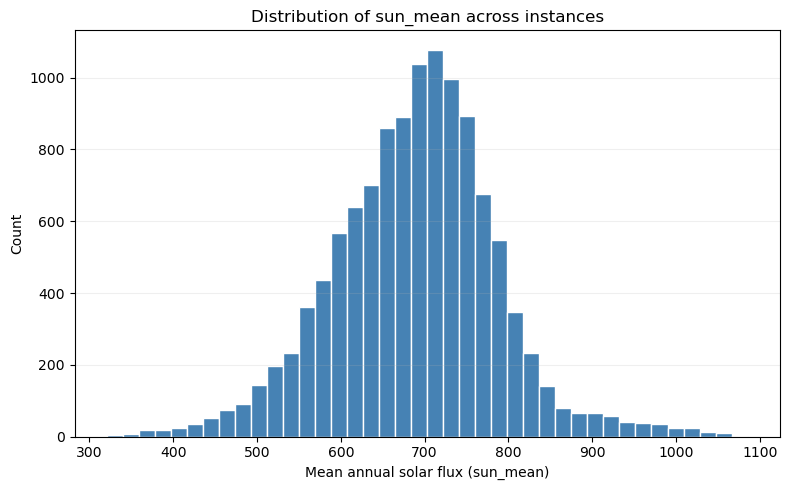

In [15]:
# Plot distribution of sun_mean values
vals = combined_gdf_sun["sun_mean"].dropna()
plt.figure(figsize=(8, 5))
plt.hist(vals, bins=40, color="steelblue", edgecolor="white")
plt.xlabel("Mean annual solar flux (sun_mean)")
plt.ylabel("Count")
plt.title("Distribution of sun_mean across instances")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()


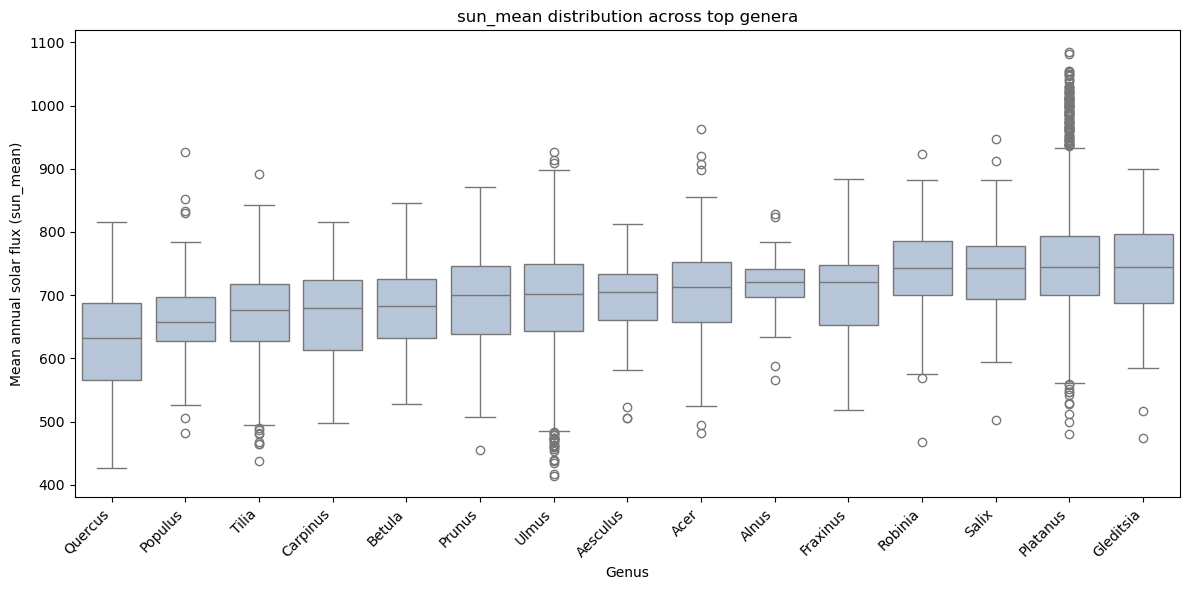

In [16]:
# Plot distribution of sun_mean across genus
import seaborn as sns

# Detect genus column automatically
possible_genus_cols = [c for c in combined_gdf_sun.columns if "genus" in c.lower()]
if not possible_genus_cols:
    raise ValueError(f"No genus-like column found. Columns: {list(combined_gdf_sun.columns)}")
genus_col = possible_genus_cols[0]

# Prepare data
plot_df = combined_gdf_sun[[genus_col, "sun_mean"]].dropna()
# Focus on top N genera by sample size to keep the plot readable
TOP_N = 15
top_genera = plot_df[genus_col].value_counts().head(TOP_N).index
plot_df = plot_df[plot_df[genus_col].isin(top_genera)]

# Order genera by median sun_mean
order = (
    plot_df.groupby(genus_col)["sun_mean"].median().sort_values().index
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x=genus_col, y="sun_mean", order=order, color="lightsteelblue")
plt.xlabel("Genus")
plt.ylabel("Mean annual solar flux (sun_mean)")
plt.title("sun_mean distribution across top genera")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
